<h1>Quench BCS $s$-wave superconductor on the plane</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

<h2>Pauli matrices</h2>

In [2]:
s0 = np.array([[1,0],[0,1]],dtype=complex)
s1 = np.array([[0,1],[1,0]],dtype=complex)
s2 = np.array([[0,-1j],[1j,0]],dtype=complex)
s3 = np.array([[1,0],[0,-1]],dtype=complex)

def product_1(a,b):
  return np.einsum('...ij,...jk->...ik',a,b)

def product_2(a,b):
  return np.einsum('...,ij->...ij',a,b)

def product_3(a,b):
  return np.einsum('...ij,...->...ij',a,b)

def commutator_1(a,b):
  return product_1(a,b)-product_1(b,a)

<h2>Mean-field evolution</h2>

In [3]:
def hamiltonian(eps,delta):
  return product_2(eps,s3)-product_2(delta,s1)

def get_order_parameter(rho):
  return rho[...,1,0].sum()/norm

def get_density(rho):
  return rho[...,0,0].sum()/norm

def rho_equilibrium(eps,delta):
  h = hamiltonian(eps,delta)
  e_qp = np.sqrt(eps**2+delta**2)
  return 0.5*(s0-product_3(h,1/e_qp))

def inverse_self_consistency(eps,delta):
  e_qp = np.sqrt(eps**2+delta**2)
  return 2/((1/e_qp).sum()/norm)

def mf_evolution(rho_0,eps,interac,time):
    
  def rho_dot(rho,t):
    delta = interac(t)*get_order_parameter(rho)
    h = hamiltonian(eps,delta)
    return 1j*commutator_1(rho,h)
  
  class MeanField():
    pass

  mf = MeanField()
  mf.eps = eps
  mf.time = time
  mf.interac = interac
  mf.rho = rho_0
  mf.phi = np.empty_like(mf.time,dtype=complex)
  mf.density = np.empty_like(mf.time,dtype=complex)
  mf.phi[0] = get_order_parameter(mf.rho)
  mf.density[0] = get_density(mf.rho)
  dt = time[1]-time[0]
  
  for i,t in enumerate(tqdm(mf.time[:-1])):
    mf.rho = runge_kutta_step(mf.rho,rho_dot,t,dt)
    mf.phi[i+1] = get_order_parameter(mf.rho)
    mf.density[i+1] = get_density(mf.rho)
  mf.delta = interac(time)*mf.phi

  return mf

<h2>Runge-Kutta integrator</h2>

In [4]:
def runge_kutta_step(y,y_dot,t,dt):
  a1 = y_dot(y,t)
  a2 = y_dot(y+a1*0.5*dt,t+0.5*dt)
  a3 = y_dot(y+a2*0.5*dt,t+0.5*dt)
  a4 = y_dot(y+a3*dt,t+dt)
  return y + dt/6.*(a1+a4) + dt/3.*(a2+a3)

def runge_kutta(y0,y_dot,ts):
  ys = np.empty((*ts.shape,*y0.shape),dtype=complex)
  ys[0] = y0
  dt = ts[1]-ts[0]
  for i in tqdm(range(len(ts)-1)):
    ys[i+1] = runge_kutta_step(ys[i],y_dot,ts[i],dt)
  return ys

<h2>Example</h2>

In [5]:
w,n = 50,100
eps = np.linspace(-w,w,n)
norm = n

In [6]:
interac = inverse_self_consistency(eps=eps,delta=1)
rho_0_1 = rho_equilibrium(eps=eps,delta=0.001)
mf_1 = mf_evolution(rho_0_1,eps,lambda t: interac,time=np.arange(0,50,0.01))

100%|████████████████████████████████████████| 4999/4999 [00:03<00:00, 1603.49it/s]


In [7]:
mf_1.phi[0]

(5.816790117847663e-05+0j)

In [8]:
mf_1.delta[0]

(0.001273589025640217+0j)

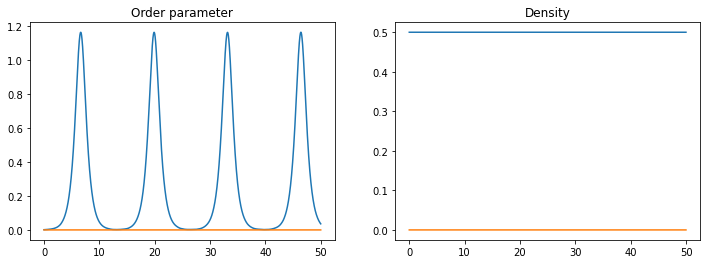

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Order parameter')
plt.plot(mf_1.time,mf_1.delta.real)
plt.plot(mf_1.time,mf_1.delta.imag)
plt.subplot(122)
plt.title('Density')
plt.plot(mf_1.time,mf_1.density.real)
plt.plot(mf_1.time,mf_1.density.imag)

<h2>Barankov et al.</h2>

In [10]:
w,n = 50,5000
eps = np.linspace(-w,w,n)
norm = n

In [11]:
rho_0_1 = rho_equilibrium(eps=eps,delta=0.001)
rho_0_2 = rho_equilibrium(eps=eps,delta=0.2)
rho_0_3 = rho_equilibrium(eps=eps,delta=4)
rho_0_4 = rho_equilibrium(eps=eps,delta=5.2)

In [12]:
mf_1 = mf_evolution(rho_0_1,eps,lambda t: interac,time=np.arange(0,50,0.01))
mf_2 = mf_evolution(rho_0_2,eps,lambda t: interac,time=np.arange(0,50,0.01))
mf_3 = mf_evolution(rho_0_3,eps,lambda t: interac,time=np.arange(0,50,0.01))
mf_4 = mf_evolution(rho_0_4,eps,lambda t: interac,time=np.arange(0,50,0.01))

100%|██████████████████████████████████████████| 4999/4999 [01:31<00:00, 54.86it/s]


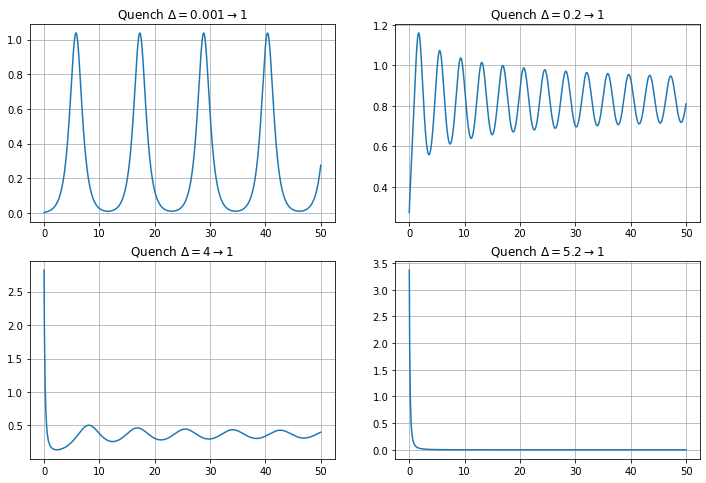

In [13]:
plt.figure(figsize=(12,8))
plt.subplot(221); plt.grid()
plt.title(r'Quench $\Delta=0.001 \rightarrow 1$')
plt.plot(mf_1.time,mf_1.delta.real)
plt.subplot(222); plt.grid()
plt.title(r'Quench $\Delta=0.2 \rightarrow 1$')
plt.plot(mf_2.time,mf_2.delta.real)
plt.subplot(223); plt.grid()
plt.title(r'Quench $\Delta=4 \rightarrow 1$')
plt.plot(mf_3.time,mf_3.delta.real)
plt.subplot(224); plt.grid()
plt.title(r'Quench $\Delta=5.2 \rightarrow 1$')
plt.plot(mf_4.time,mf_4.delta.real)